In [1]:
import pymc3 as pm
from pymc3.glm import glm
import numpy as np
import pandas as pd
import datetime
import scipy.stats

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

from sklearn.linear_model import LinearRegression

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [83]:
def gen_data(N, num_teams, intercept=70):
    np.random.seed(13)
    indices = np.array([np.random.choice(list(range(num_teams)), 2, replace=False) for x in range(N)])
    data = []
    for idx in indices:
        x = np.zeros(num_teams)
        x[idx] = 1
        data.append(x)
    data = np.array(data)
    true_coefs = np.random.normal(0, 3, num_teams)
    true_coefs = true_coefs - np.mean(true_coefs)
    true_intercept = intercept
    
    mus = np.dot(data, true_coefs[:, np.newaxis]) + true_intercept
    std = 5
    return data, np.random.normal(mus, std), indices, true_coefs

def get_points_matrix(home_idx, away_idx, home_ppp, away_ppp, is_neutral, append_intercept=False, is_log=False):
    home_off_mat = pd.get_dummies(home_idx, prefix='o')
    away_def_mat = pd.get_dummies(away_idx, prefix='d')
    df1 = pd.concat([home_off_mat, away_def_mat], axis=1)
    df1['ppp'] = home_ppp if not is_log else np.log(home_ppp)
    df1['home'] = (~is_neutral).astype(int)
    df1['intercept'] = 1

    home_def_mat = pd.get_dummies(home_idx, prefix='d')
    away_off_mat = pd.get_dummies(away_idx, prefix='o')
    df2 = pd.concat([away_off_mat, home_def_mat], axis=1)
    df2['ppp'] = away_ppp if not is_log else np.log(away_ppp)
    df2['home'] = is_neutral.astype(int) - 1.0
    df2['intercept'] = 1

    df = pd.concat([df1, df2], axis=0).sort_index()
    predictors = ['o_%s' % i for i in range(num_teams - 1)] + ['d_%s' % i for i in range(num_teams - 1)] + ['home']
    if append_intercept:
        predictors = ['intercept'] + predictors
    X = df[predictors].values
    y = df['ppp'].values
    return X, y

# get the data we need from the database
year = 2015
all_teams = pd.read_sql("SELECT ncaa, ncaaid, kenpom, conf FROM teams", DB.conn)
B10 = all_teams[all_teams.conf == 'B10']['ncaaid'].values
games_df, stacked, teams = util.get_data(year)
games_df = games_df[(games_df['hteam_id'].isin(B10)) & (games_df['ateam_id'].isin(B10))]
teams = teams[teams['team_id'].isin(B10)]
teams['i_team'] = np.arange(teams.shape[0])
stacked = stacked[(stacked['team_id'].isin(B10)) & (stacked['opp_id'].isin(B10))]
games_df = games_df.sort('dt')  # sort by date ascending
kenpom = pd.read_sql("SELECT team, adjt FROM kenpom_ranks WHERE year = %s" % year, DB.conn)
teams = teams.merge(all_teams, left_on='team_id', right_on='ncaaid')
teams = teams.merge(kenpom, how='left', left_on='kenpom', right_on='team').drop(['team', 'kenpom', 'ncaaid'], 1)
num_teams = teams.shape[0]
print("Got data for %s games and %s teams, between %s and %s" % (games_df.shape[0], num_teams,
                                                   datetime.datetime.strftime(games_df['dt'].min(), "%m-%d-%Y"),
                                                  datetime.datetime.strftime(games_df['dt'].max(), "%m-%d-%Y")))

Got data for 138 games and 14 teams, between 12-30-2014 and 03-15-2015


In [98]:
games_df.shape, stacked.shape, teams.shape
# teams['i'] = np.arange(teams.shape[0])
team_index = dict(teams[['team_id', 'i_team']].values)
games_df['i_hteam'] = games_df['hteam_id'].map(lambda x: int(team_index[x]))
games_df['i_ateam'] = games_df['ateam_id'].map(lambda x: int(team_index[x]))
stacked['i_team'] = stacked['team_id'].map(lambda x: int(team_index[x]))
stacked['i_opp'] = stacked['opp_id'].map(lambda x: int(team_index[x]))

In [99]:
home_idx = games_df['i_hteam'].values
away_idx = games_df['i_ateam'].values
home_off_mat = pd.get_dummies(home_idx, prefix='o')
away_def_mat = pd.get_dummies(away_idx, prefix='d')
df1 = pd.concat([home_off_mat, away_def_mat], axis=1)
df1['ppp'] = games_df['hppp'].values
df1['home'] = (~games_df['neutral']).astype(int)
df1['intercept'] = 1
df1['dt'] = games_df['dt'].values

home_def_mat = pd.get_dummies(home_idx, prefix='d')
away_off_mat = pd.get_dummies(away_idx, prefix='o')
df2 = pd.concat([away_off_mat, home_def_mat], axis=1)
df2['ppp'] = games_df['appp'].values
df2['home'] = games_df['neutral'].astype(int) - 1.0
df2['intercept'] = 1
df2['dt'] = games_df['dt'].values

df = pd.concat([df1, df2], axis=0).sort_index()

In [100]:
df.head()

,o_0,o_1,o_2,o_3,o_4,o_5,o_6,o_7,o_8,o_9,...,d_8,d_9,d_10,d_11,d_12,d_13,ppp,home,intercept,dt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.762987,0.0,1,2014-12-30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.828595,0.0,1,2014-12-30
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.184814,-1.0,1,2014-12-30
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.063395,1.0,1,2014-12-30
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.933238,-1.0,1,2014-12-30


In [101]:
def home(team_is_home, is_neutral):
    if is_neutral:
        return 0
    elif team_is_home:
        return 1
    else:
        return -1
stacked['home'] = stacked.apply(lambda row: home(row.team_id == row.hteam_id, row.neutral), 1)
stacked.head()

,dt,hteam_id,ateam_id,home_score,away_score,neutral,neutral_site,home_outcome,numot,game_id,...,team,team_id,pts,poss,ppp,opp_id,i_team,i_opp,season,home
6,2015-03-15,416.0,796.0,69,80,True,"United Center Chicago, IL",False,1,3817070,...,Wisconsin,796.0,80,64.500,1.240310,416.0,13,4,2015,0
7,2015-03-14,559.0,796.0,51,71,True,"Chicago, Ill. | United Center",False,0,3816358,...,Wisconsin,796.0,71,51.700,1.373308,559.0,13,11,2015,0
8,2015-03-13,796.0,418.0,71,60,True,"United Center, Chicago, IL",True,0,3814628,...,Wisconsin,796.0,71,53.600,1.324627,418.0,13,5,2015,0
9,2015-03-08,518.0,796.0,48,72,False,None,False,0,3809069,...,Wisconsin,796.0,72,59.425,1.211611,518.0,13,9,2015,-1
10,2015-03-05,428.0,796.0,63,76,False,None,False,0,3805265,...,Wisconsin,796.0,76,61.700,1.231767,428.0,13,6,2015,-1


In [102]:
# N = 1000
# num_teams = 10
# data, samples, indices, true_coefs = gen_data(N, num_teams)
# X = np.append(np.ones(N)[:, np.newaxis], data[:, 1:], axis=1)
# y = samples

home_idx
X, y = get_points_matrix(games_df['i_hteam'].values, games_df['i_ateam'].values, games_df['hppp'].values, 
        games_df['appp'].values, games_df['neutral'].values, append_intercept=True, is_log=False)

In [103]:
np.where(X[:, 1:-1] == 1)[1][:20], num_teams

(array([12, 21,  8, 25,  2, 22,  9, 15,  0, 18,  5, 13,  4, 16,  3, 17,  7,
        14,  1, 20]), 14)

In [212]:
team_idx = stacked['i_team'].astype(int).values
opp_idx = stacked['i_opp'].astype(int).values
home_idx = stacked['home'].astype(int).values
with pm.Model() as model:
    off_coefs = pm.Uniform('off_coefs', -1, 1, shape=num_teams)
    def_coefs = pm.Uniform('def_coefs', -1, 1, shape=num_teams)
    off_centered = pm.Deterministic('off_centered', off_coefs - T.mean(off_coefs) + T.mean(def_coefs))
    def_centered = pm.Deterministic('def_centered', def_coefs - T.mean(def_coefs) + T.mean(off_coefs))
    std = pm.Uniform('std', 0.01, 0.3)
#     intercept = pm.Normal('intercept', 1, sd=10)
    home = pm.Normal('home', 0, sd=1)
    
    mus = off_centered[team_idx] + def_centered[opp_idx] + home*home_idx
    target = pm.Normal('target', mu=mus, sd=std, observed=stacked['ppp'].values)
    start = pm.find_MAP()
#     print(start['intercept'])
#     step = pm.Metropolis()
    step1 = pm.NUTS([off_centered, def_centered, std, home])
#     step2 = pm.Metropolis([intercept])
    traces = pm.sample(300, step=step1, start=start, progressbar=True)

Applied interval-transform to off_coefs and added transformed off_coefs_interval to model.
Applied interval-transform to def_coefs and added transformed def_coefs_interval to model.
Applied interval-transform to std and added transformed std_interval to model.
 [-----------------100%-----------------] 300 of 300 complete in 1.1 sec

In [213]:
with model:
    traces = pm.sample(3000, step=step1, progressbar=True)

 [-----------------100%-----------------] 3000 of 3000 complete in 9.7 sec

In [207]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
y_pred = lr.predict(X)
beta_means = lr.coef_.ravel()
off_means = beta_means[1:num_teams]
def_means = beta_means[num_teams:2*num_teams - 1]
sy = 1 / (X.shape[0] - num_teams - 1) * np.sum((y - y_pred)**2)
beta_cov = np.sqrt(np.linalg.pinv(np.dot(X.T, X)) * sy)
beta_sigmas = beta_cov[np.arange(beta_cov.shape[0]), np.arange(beta_cov.shape[0])]
off_sigmas = beta_sigmas[1:num_teams]
def_sigmas = beta_sigmas[num_teams:2*num_teams - 1]

In [208]:
off_means.shape, def_means.shape

((13,), (13,))

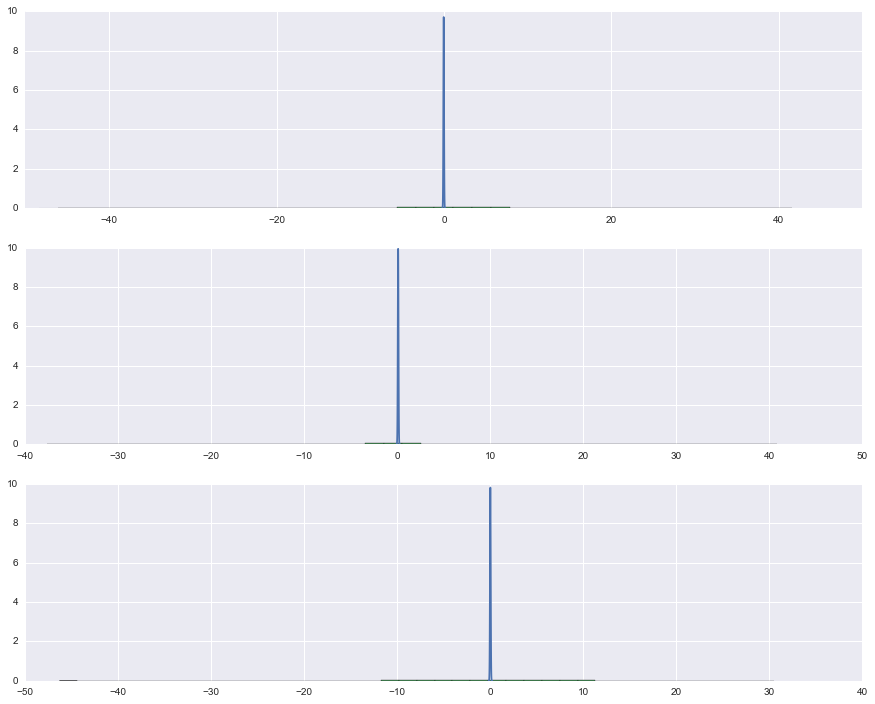

In [242]:
fig, axs = plt.subplots(3, 1, figsize=(15, 12))
for i, ax in enumerate(axs.reshape(-1)):
    bayes_samples = traces['def_centered'][:,i] - np.mean(traces['def_centered'][:, i])
    mean = def_means[i] - np.mean(def_means)
    sigma = def_sigmas[i]
    x = np.linspace(mean - 5*sigma, mean + 5*sigma, 100)
    ax.plot(x, mlab.normpdf(x, mean, sigma))
    ax.hist(bayes_samples, normed=True, bins=40)

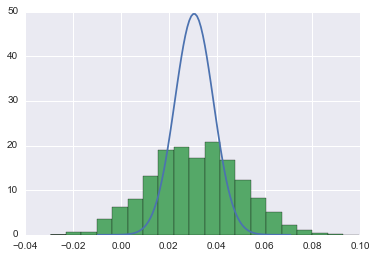

In [210]:
mean = beta_means[0] + np.mean(off_means) + np.mean(def_means)
sigma = beta_sigmas[0]
mean, sigma = beta_means[-1], beta_sigmas[-1]
x = np.linspace(mean - 5*sigma, mean + 5*sigma, 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))
_ = plt.hist(traces['home'], normed=True, bins=20)

In [312]:
with pm.Model() as model:
    off_coefs = pm.Normal('off_coefs', 0, sd=100, shape=3)
    def_coefs = pm.Normal('def_coefs', 0, sd=100, shape=3)
#     off_centered = pm.Deterministic('off_centered', off_coefs - T.mean(off_coefs))
    def_centered = pm.Deterministic('def_centered', def_coefs - T.mean(def_coefs) + T.mean(off_coefs))
    std = pm.Uniform('std', 0.01, 20)
    home = pm.Normal('home', 0, sd=5)
#     intercept = pm.Normal('intercept', 1, sd=10)
    
    mus = off_coefs[oidx] + def_centered[didx] + home * home_idx
    target = pm.Normal('target', mu=mus, sd=std, observed=target)
    start = pm.find_MAP()
    print(start)
    step1 = pm.NUTS([off_coefs, def_coefs, std, home])
    traces = pm.sample(500, step=step1, start=start, progressbar=True)

Applied interval-transform to std and added transformed std_interval to model.
{'off_coefs': array([ 37.31465656,  28.51821262,  37.91494715]), 'std_interval': array(-2.6270940254204387), 'def_coefs': array([  5.60002178, -10.59892782,   4.99890604]), 'home': array(1.8321755936113275)}
 [-----------------100%-----------------] 500 of 500 complete in 3.4 sec

 [-----------------100%-----------------] 3000 of 3000 complete in 15.9 sec

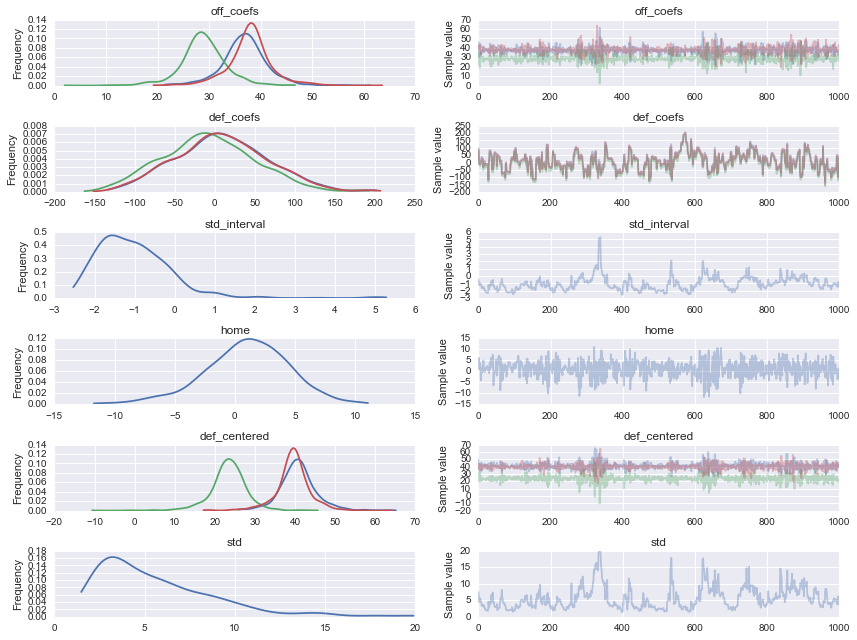

In [313]:
with model:
    traces = pm.sample(3000, step=step1, progressbar=True)
history = 1000
_ = pm.traceplot(traces[-history:], figsize=(12, len(traces.varnames) * 1.5))

In [311]:
data = np.array([[0, 1, 0, 0, 0, 1, 1], [0, 0, 1, 0, 1, 0, -1], [1, 0, 0, 0, 0, 1, -1], [0, 0, 1, 1, 0, 0, 1], 
                 [1, 0, 0, 0, 1, 0, -1], [0, 1, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 0, -1], [0, 1, 0, 1, 0, 0, 1]])
# data = np.append(data, np.ones(data.shape[0])[:, np.newaxis], 1)
y = np.array([70, 60, 75, 80, 60, 68, 59, 73])
print(np.linalg.cond(data))
oidx = np.where(data[:, :3] > 0)[1]
didx = np.where(data[:, 3:6] > 0)[1]
home_idx = data[:, -1]
data, oidx, didx, home_idx

1.23701413359e+17


(array([[ 0,  1,  0,  0,  0,  1,  1],
        [ 0,  0,  1,  0,  1,  0, -1],
        [ 1,  0,  0,  0,  0,  1, -1],
        [ 0,  0,  1,  1,  0,  0,  1],
        [ 1,  0,  0,  0,  1,  0, -1],
        [ 0,  1,  0,  1,  0,  0,  1],
        [ 1,  0,  0,  0,  1,  0, -1],
        [ 0,  1,  0,  1,  0,  0,  1]]),
 array([1, 2, 0, 2, 0, 1, 0, 1]),
 array([2, 1, 2, 0, 1, 0, 1, 0]),
 array([ 1, -1, -1,  1, -1,  1, -1,  1]))

In [305]:
dtd = np.dot(data.T, data)
dtd[-1, :] = np.array([1, 1, 1, -1, -1, -1, 0])
# dtd[-2, :] = np.array([0,0,0, 1,1,1])
dty = np.dot(data.T, y)
# dty[-2] = 0
dty[-1] = 0
dtd, dty

(array([[ 3,  0,  0,  0,  2,  1, -3],
        [ 0,  3,  0,  2,  0,  1,  3],
        [ 0,  0,  2,  1,  1,  0,  0],
        [ 0,  2,  1,  3,  0,  0,  3],
        [ 2,  0,  1,  0,  3,  0, -3],
        [ 1,  1,  0,  0,  0,  2,  0],
        [ 1,  1,  1, -1, -1, -1,  0]]),
 array([194, 211, 140, 221, 179, 145,   0]))

In [318]:
coef = np.dot(np.linalg.pinv(dtd), dty)
y_pred = np.dot(data, coef)
sy = np.sum((y - y_pred)**2)
cov = np.sqrt(np.linalg.pinv(np.dot(data.T, data)) * sy)
sigmas = cov.diagonal()
off_sigmas = sigmas[:3]
def_sigmas = sigmas[3:6]
off_means = coef[:3]
def_means = coef[3:6]
off_means, def_means, coef[-1]

(array([ 37.95765027,  27.87568306,  37.91666667]),
 array([ 39.54234973,  24.62431694,  39.58333333]),
 2.9016393442622963)

In [273]:
lr = LinearRegression(fit_intercept=False)
lr.fit(data, target)
lr.coef_, lr.intercept_, np.mean(coef)
y_pred = lr.predict(data)
beta_means = lr.coef_.ravel()
off_means = beta_means[:3]
def_means = beta_means[3:]
sy = 1 / (data.shape[0]) * np.sum((target - y_pred)**2)
beta_cov = np.sqrt(np.linalg.pinv(dtd) * sy)
beta_sigmas = beta_cov[np.arange(beta_cov.shape[0]), np.arange(beta_cov.shape[0])]
off_sigmas = beta_sigmas[:3]
def_sigmas = beta_sigmas[3:]
print(beta_means, def_means, def_sigmas, beta_cov)

[ 36.21666667  29.61666667  37.91666667  41.28333333  22.88333333
  39.58333333] [ 41.28333333  22.88333333  39.58333333] [ 1.01458119  1.01458119         nan] [[ 0.88105051         nan         nan  0.69955343         nan  0.5809475 ]
 [        nan  0.88105051         nan         nan  0.69955343  0.5809475 ]
 [ 0.41079192  0.41079192  1.125              nan         nan  0.5809475 ]
 [ 0.48605555         nan         nan  1.01458119         nan         nan]
 [        nan  0.48605555         nan         nan  1.01458119         nan]
 [ 0.91855865  0.91855865  1.125              nan         nan         nan]]


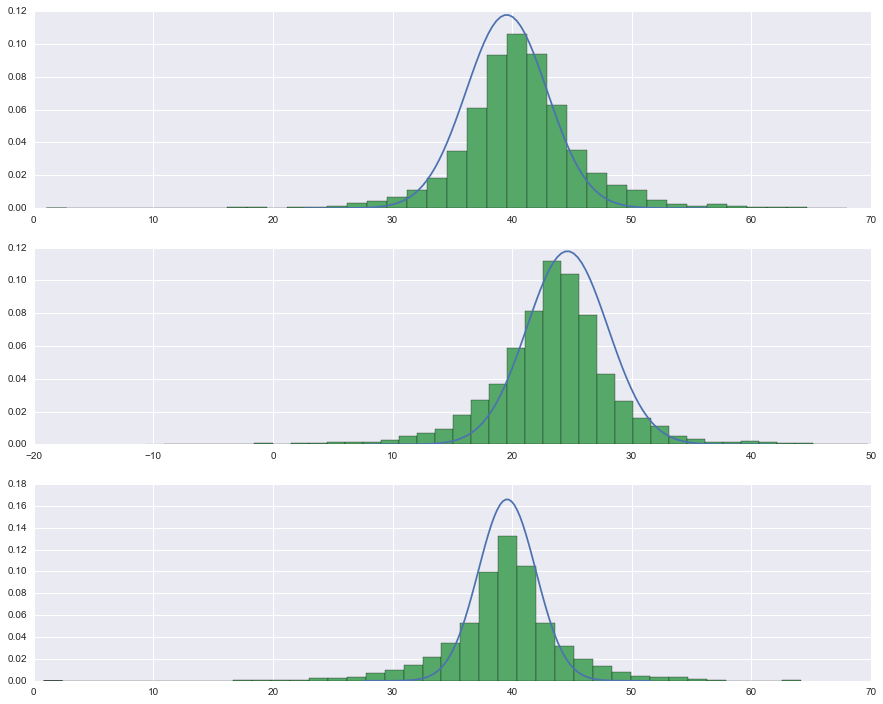

In [317]:
fig, axs = plt.subplots(3, 1, figsize=(15, 12))
for i, ax in enumerate(axs.reshape(-1)):
    bayes_samples = traces['def_centered'][:,i] 
    mean = def_means[i]
    sigma = def_sigmas[i]
    x = np.linspace(mean - 5*sigma, mean + 5*sigma, 100)
    ax.plot(x, mlab.normpdf(x, mean, sigma))
    ax.hist(bayes_samples, normed=True, bins=40)

Object `np.linalg.rank` not found.
